# Forecast Police Service Calls

***

## Libraries

In [93]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
#import plotly.express as px
#!pip install --disable-pip-version-check -q seaborn==0.11.0
#import seaborn as sns
import datetime
#%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker.estimator import Estimator

np.random.seed(1)

***

## Variables - Setup

In [94]:
prefix = "Forecasting/Calls"

db_name = "sdpd"
bucket = 'sdpd-bucket' 
region = boto3.Session().region_name
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

sagemaker_session = sagemaker.Session()
role = get_execution_role()
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

s3 = boto3.client("s3")
encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

Data_length = 1000
prediction_length = 48
context_length = 480


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


***

## Functions

In [95]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [96]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding=encoding,
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

***

## Retrive Data

In [97]:
Stops_Hourly = """SELECT * FROM {}.{}
    order by date_time desc
     LIMIT 1000
     """.format(
    db_name, 'calls_hour'
)

print(Stops_Hourly)

SELECT * FROM sdpd.calls_hour
    order by date_time desc
     LIMIT 1000
     


In [98]:
calls = pd.read_sql(Stops_Hourly, conn)
calls['count'] = calls['count'].astype(int)
calls = calls.sort_values(by='date_time', ascending=True)
calls['timestamp'] = pd.to_datetime(calls.date_time).dt.tz_localize(None)
#calls['date_time'] = calls['date_time'].isoformat()
calls.head(5)

,date_time,count,year,hour,timestamp
999,2023-02-17 08:00:00+00:00,74,2023,8,2023-02-17 08:00:00
998,2023-02-17 09:00:00+00:00,68,2023,9,2023-02-17 09:00:00
997,2023-02-17 10:00:00+00:00,57,2023,10,2023-02-17 10:00:00
996,2023-02-17 11:00:00+00:00,76,2023,11,2023-02-17 11:00:00
995,2023-02-17 12:00:00+00:00,93,2023,12,2023-02-17 12:00:00


In [99]:
call_data= calls['count'].values

In [100]:
#last_row = calls.iloc[-1:]
first_row = calls.iloc[:1]
#first_date = last_row['timestamp']
first_date = first_row['timestamp']
first_date =pd.to_datetime(first_date)
#first_date = first_row['timestamp']
#first_timestamp = first_date.iloc[0].to_pydatetime()
data_length = calls.shape[0]
freq='H'

In [101]:
print(first_date[Data_length-1])

2023-02-17 08:00:00


In [102]:
time_series_calls =[]
index = pd.date_range(start=first_date[Data_length-1], freq=freq, periods=data_length)
time_series_calls.append(pd.Series(data=call_data , index=index))

In [103]:
time_series_calls

[2023-02-17 08:00:00    74
 2023-02-17 09:00:00    68
 2023-02-17 10:00:00    57
 2023-02-17 11:00:00    76
 2023-02-17 12:00:00    93
                        ..
 2023-03-30 19:00:00    49
 2023-03-30 20:00:00    54
 2023-03-30 21:00:00    52
 2023-03-30 22:00:00    52
 2023-03-30 23:00:00    23
 Freq: H, Length: 1000, dtype: int64]

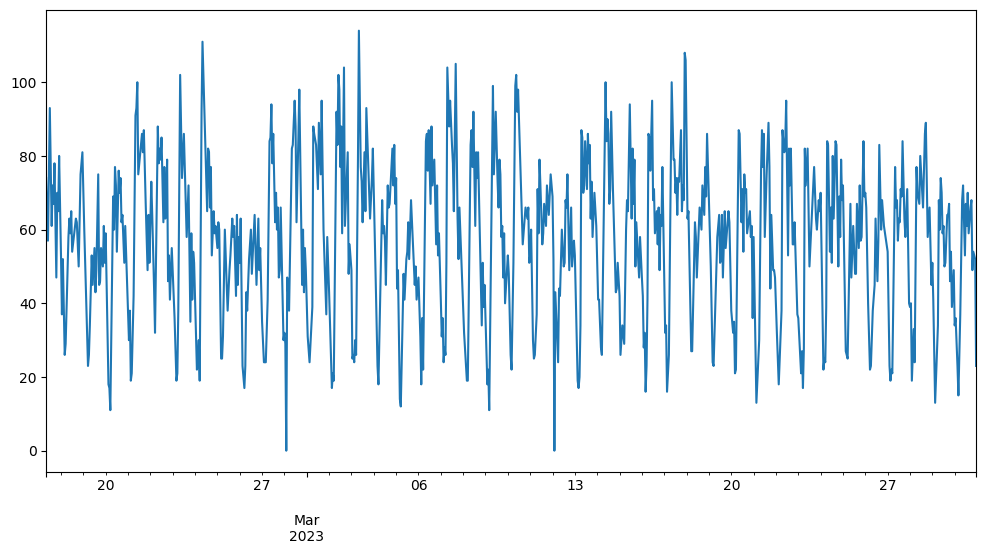

In [104]:
plt.figure(figsize=(12, 6))
plt.style.use('fast')
time_series_calls[0].plot()
plt.show()

***

## Spliy Train and Test

In [105]:
time_series_training = []
for ts in time_series_calls:
    time_series_training.append(ts[:-prediction_length])

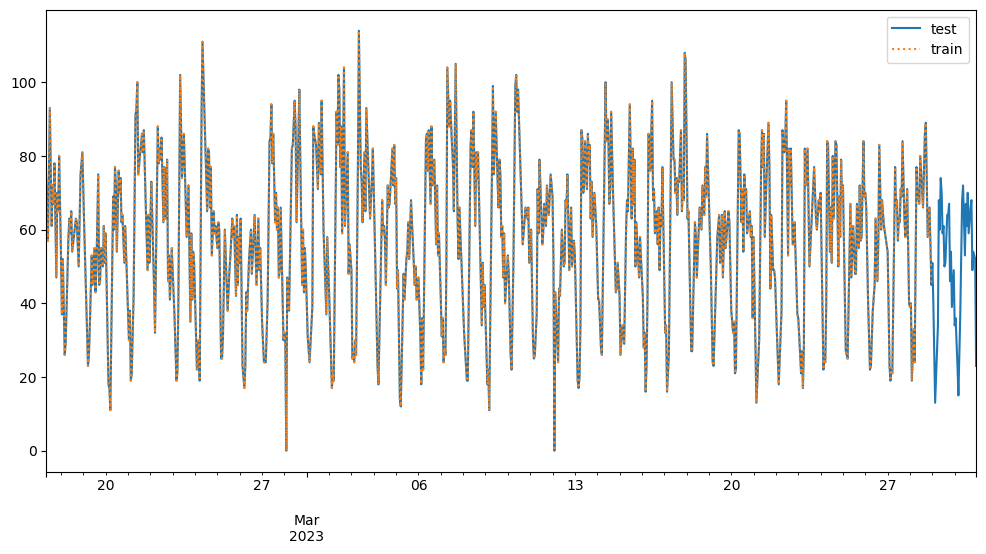

In [106]:
plt.figure(figsize=(12, 6))
time_series_calls[0].plot(label="test")
time_series_training[0].plot(label="train", ls=":")
plt.legend()
plt.show()

***

## Upload Train and Test data as JSON

In [107]:
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in time_series_calls:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
        

s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

***

## Train Model

In [108]:
# Create the estimator object
estimator = Estimator(
                    sagemaker_session=sagemaker_session,
                    image_uri=image_uri,
                    role=role,
                    instance_count=1,
                    instance_type="ml.c5.xlarge",
                    base_job_name="SDPD-Calls",
                    output_path=f"s3://{s3_output_path}",
                   hyperparameters=hyperparameters,
                    metric_definitions=[
                        {'Name': 'train:accuracy', 'Regex': 'Accuracy=(.*?);'},
                        {'Name': 'train:loss', 'Regex': 'Loss=(.*?);'}
                    ]
)

In [109]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    base_job_name="SDPD-Calls",
    output_path=f"s3://{s3_output_path}",
)

In [110]:
metrics_definitions = [
    {"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"},
    {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
    {"Name": "test:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "test:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
]

In [111]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "student-T",
    "epochs": "50",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "30",
}

In [112]:
# Set accuracy and loss as the metrics to optimize for during training
#estimator.set_metric_definitions([
  #  {'Name': 'train:accuracy', 'Regex': 'accuracy=(.*?);'},
    #{"Name": "test:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    #{'Name': 'train:loss', 'Regex': 'loss=(.*?);'}
#])

In [113]:
estimator.set_hyperparameters(**hyperparameters)

In [114]:
data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: SDPD-Calls-2023-04-06-14-27-47-017


2023-04-06 14:27:50 Starting - Starting the training job...
2023-04-06 14:28:06 Starting - Preparing the instances for training...
2023-04-06 14:28:51 Downloading - Downloading input data...
2023-04-06 14:29:16 Training - Downloading the training image......
2023-04-06 14:30:27 Training - Training image download completed. Training in progress...Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[04/06/2023 14:30:36 INFO 139769320191808] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': '

***

## Model Metrics

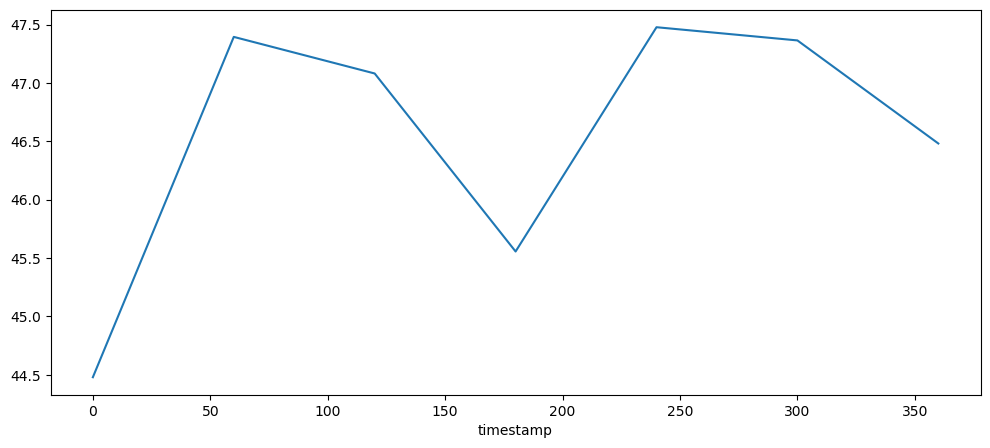

In [127]:
training_job_name = estimator.latest_training_job.name
metric_name = 'train:throughput'
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe.plot(kind='line',
                       figsize=(12,5),
                       x='timestamp',
                       y='value', 
                       #style='b.', 
                       legend=False)
#plt.pyplot.ylabel(metric_name)
#plt.set_ylabel(metric_name)
plt.show()

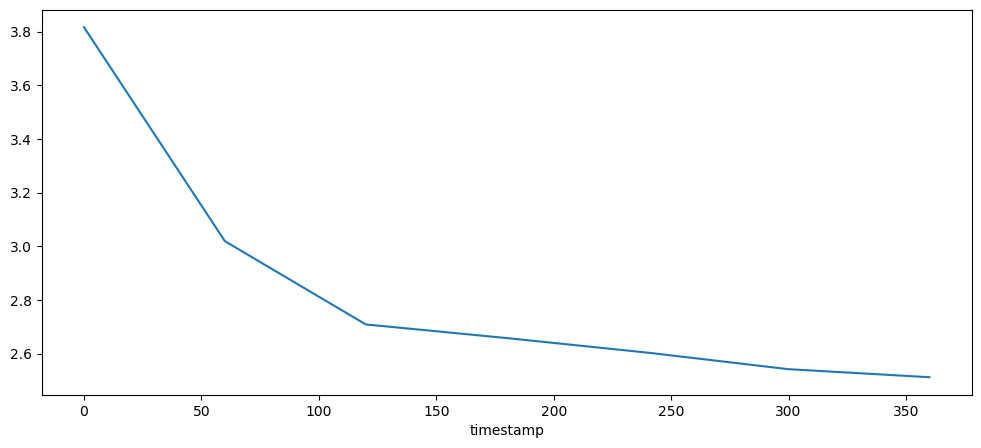

In [128]:
training_job_name = estimator.latest_training_job.name
metric_name = 'train:loss'
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe.plot(kind='line',
                       figsize=(12,5),
                       x='timestamp',
                       y='value', 
                       #style='b.', 
                       legend=False)
#plt.pyplot.ylabel(metric_name)
#plt.set_ylabel(metric_name)
plt.show()

In [116]:
training_job_name = estimator.latest_training_job.name
metric_name = 'test:mean_wQuantileLoss'
metrics= TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name])
metrics.dataframe()

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.13087


In [117]:
training_job_name = estimator.latest_training_job.name
metric_name = 'test:RMSE'
metrics= TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name])
metrics.dataframe()

,timestamp,metric_name,value
0,0.0,test:RMSE,10.213057


In [118]:
job_analytics_data = estimator.training_job_analytics
analytics = job_analytics_data.dataframe()
analytics

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.130870
1,0.0,train:loss:batch,3.920187
2,60.0,train:loss:batch,3.010135
3,120.0,train:loss:batch,2.739789
4,180.0,train:loss:batch,2.681580
5,240.0,train:loss:batch,2.558683
6,300.0,train:loss:batch,2.635086
7,360.0,train:loss:batch,2.578952
8,0.0,train:progress,2.000000
9,60.0,train:progress,12.000000


In [119]:
job_name = estimator.latest_training_job.name
analytics = sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=job_name
)['FinalMetricDataList'][6]['Value']
print('Training job RMSE: {}'.format(analytics))

Training job RMSE: 10.213056564331055


In [120]:
client = boto3.client('sagemaker')
description = client.describe_training_job(TrainingJobName=job_name)

In [121]:
# retrieve the RMSE metric from the training job description
rmse = description['FinalMetricDataList'][6]['Value']
print('Training job RMSE: {}'.format(rmse))

Training job RMSE: 10.213056564331055


***

## Endpoint 

In [122]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

INFO:sagemaker:Creating model with name: SDPD-Calls-2023-04-06-14-27-47-017
INFO:sagemaker:Creating endpoint-config with name SDPD-Calls-2023-04-06-14-27-47-017
INFO:sagemaker:Creating endpoint with name SDPD-Calls-2023-04-06-14-27-47-017


--------!

***

## Forecast

In [123]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [124]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series_calls[:5]

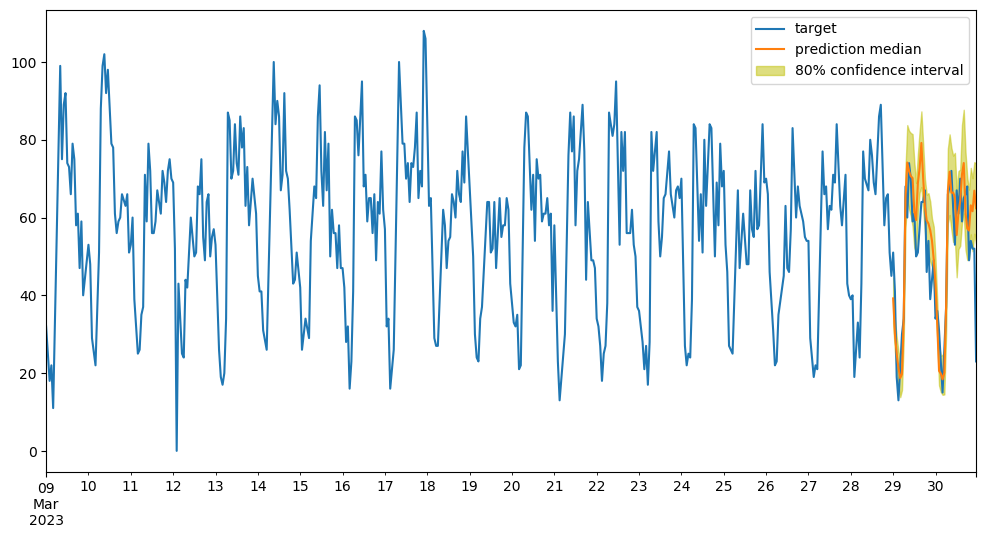

In [ ]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    #actual_data[-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [142]:
list_of_df

[                           0.1        0.5        0.9
 2023-03-29 00:00:00  32.830921  39.208332  44.565479
 2023-03-29 01:00:00  25.553350  30.083881  33.832512
 2023-03-29 02:00:00  20.782104  24.984444  29.253344
 2023-03-29 03:00:00  16.872204  21.379974  25.586891
 2023-03-29 04:00:00  13.819221  18.695726  22.846962
 2023-03-29 05:00:00  15.645162  19.734428  24.546000
 2023-03-29 06:00:00  28.641964  34.725334  41.547306
 2023-03-29 07:00:00  57.599285  65.366364  72.671295
 2023-03-29 08:00:00  64.479408  74.142593  83.766663
 2023-03-29 09:00:00  62.156841  71.965988  82.302223
 2023-03-29 10:00:00  60.366547  70.650665  81.741074
 2023-03-29 11:00:00  57.744854  70.147423  81.447983
 2023-03-29 12:00:00  52.255203  61.485302  74.228218
 2023-03-29 13:00:00  50.933277  59.343891  68.884735
 2023-03-29 14:00:00  61.179218  68.825943  76.280396
 2023-03-29 15:00:00  66.486282  72.742126  82.284302
 2023-03-29 16:00:00  67.839882  79.187805  87.291817
 2023-03-29 17:00:00  61.940

In [126]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: SDPD-Calls-2023-04-06-14-27-47-017


***

## Hyperparameter Tunning

In [139]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

tuner = HyperparameterTuner(
    estimator,
    objective_type='Minimize',
    objective_metric_name='test:RMSE',
    hyperparameter_ranges={
                                                'dropout_rate': sagemaker.tuner.ContinuousParameter(0.2, 0.4),
                                                'likelihood': sagemaker.tuner.CategoricalParameter(['student-t', 'gaussian']),
                                                'context_length': sagemaker.tuner.IntegerParameter(30, 60),
                                                'embedding_dimension': sagemaker.tuner.IntegerParameter(10, 20),
                                                'num_layers': sagemaker.tuner.IntegerParameter(1, 2),
                                                'learning_rate': sagemaker.tuner.ContinuousParameter(0.001, 0.01),
                                                'epochs': sagemaker.tuner.IntegerParameter(50, 100),
                                                'num_cells': sagemaker.tuner.IntegerParameter(64, 128),
                                                'mini_batch_size': sagemaker.tuner.IntegerParameter(64, 128)
                                            },
    max_jobs=9,
    max_parallel_jobs=3,
    strategy='Bayesian'
)

In [140]:
#[dropout_rate, likelihood, context_length, embedding_dimension, num_layers, learning_rate, epochs, num_cells, mini_batch_size]

In [141]:
tuner.fit(inputs=data_channels)

INFO:sagemaker:Creating hyperparameter tuning job with name: forecasting-deepar-230406-1520


..................................................................................................................................................................................................................................................................................................!


In [144]:
from pprint import pprint

tuning_job_name = tuner.latest_tuning_job.job_name

In [145]:
tuning_job_name

'forecasting-deepar-230406-1520'

In [146]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/{}">Hyper-Parameter Tuning Job</a></b>'.format(
            region, tuning_job_name
        )
    )
)

In [148]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

hp_results = HyperparameterTuningJobAnalytics(sagemaker_session=sagemaker_session,
                                              hyperparameter_tuning_job_name=tuning_job_name)

df_results = hp_results.dataframe()
df_results.shape

(9, 15)

In [152]:
df_results.sort_values("FinalObjectiveValue", ascending=1).head(5)

,context_length,dropout_rate,embedding_dimension,epochs,learning_rate,likelihood,mini_batch_size,num_cells,num_layers,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
8,47.0,0.285159,12.0,74.0,0.001118,gaussian,75.0,105.0,2.0,forecasting-deepar-230406-1520-001-1840935d,Completed,9.784997,2023-04-06 15:21:32+00:00,2023-04-06 15:29:26+00:00,474.0
6,58.0,0.245874,18.0,61.0,0.009011,student-t,107.0,100.0,2.0,forecasting-deepar-230406-1520-003-36ee3729,Completed,10.945030,2023-04-06 15:21:35+00:00,2023-04-06 15:29:49+00:00,494.0
1,34.0,0.210972,11.0,91.0,0.005084,gaussian,126.0,117.0,2.0,forecasting-deepar-230406-1520-008-ee50f553,Completed,11.133390,2023-04-06 15:34:45+00:00,2023-04-06 15:44:49+00:00,604.0
0,55.0,0.349304,10.0,63.0,0.001000,gaussian,64.0,103.0,2.0,forecasting-deepar-230406-1520-009-e6075581,Completed,11.318421,2023-04-06 15:36:31+00:00,2023-04-06 15:41:09+00:00,278.0
4,52.0,0.381565,13.0,81.0,0.003232,gaussian,77.0,64.0,2.0,forecasting-deepar-230406-1520-005-379a470f,Completed,11.465403,2023-04-06 15:30:35+00:00,2023-04-06 15:36:08+00:00,333.0


In [151]:
df_results.sort_values("FinalObjectiveValue", ascending=1).head(1)

,context_length,dropout_rate,embedding_dimension,epochs,learning_rate,likelihood,mini_batch_size,num_cells,num_layers,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
8,47.0,0.285159,12.0,74.0,0.001118,gaussian,75.0,105.0,2.0,forecasting-deepar-230406-1520-001-1840935d,Completed,9.784997,2023-04-06 15:21:32+00:00,2023-04-06 15:29:26+00:00,474.0
